In [ ]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
from collections import deque
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Flatten, concatenate
from keras.layers import Conv2DTranspose, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from IPython.display import clear_output
from IPython.display import Image
import imageio
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Классы и функции

In [ ]:
class Minesweeper(object):
  '''
  Class of minesweeper game
  Input parameters:
    - mines_count - number of mines on playfield
    - playfield_size - length of square playfield side
  '''

  def __init__(self, mines_count, playfield_size):
    self.mines_count = mines_count
    self.playfield_size = playfield_size
    # Actions for locate all points around current point (clockwise)
    self.actions = [(-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1)]

  # Create fake playfield (need for mines placement)
  def _create_playground(self):
    self.playground = np.zeros((self.playfield_size+2,self. playfield_size+2))
    return self.playground

  # Create filed for mines placement
  def _create_minesfield(self):
    self.minesfield = np.full((self.playfield_size, self.playfield_size), 9)
    return self.minesfield

  # First step coordinates
  def _first_step(self):
    x = np.random.randint(0, self.playfield_size)
    y = np.random.randint(0, self.playfield_size)
    return (x, y)

  # Create mines in random places exept first_step_coord
  def _place_mines(self):
    first_step_coord = self._first_step()

    first_point_surround = []
    for act in self.actions:
      x1 = first_step_coord[0] + act[0]
      y1 = first_step_coord[1] + act[1]
      first_point_surround.append((x1, y1))

    self.mines_coord = []
    while len(self.mines_coord) < self.mines_count:
      x = np.random.randint(0, self.playfield_size)
      y = np.random.randint(0, self.playfield_size)

      if ((x, y) != first_step_coord) and ((x, y) not in self.mines_coord) and ((x, y) not in first_point_surround):
        self.mines_coord.append((x, y))

    return first_step_coord

  # Create stealth playfield with mines around count
  def _mines_number(self):
    mines_round =[]
    for mine in self.mines_coord:
      mines_round.append((mine[0]+1, mine[1]+1))

    field = np.zeros_like(self.playground)

    for i in range(1, self.playfield_size+1):
      for j in range(1, self.playfield_size+1):
        if (i, j) in mines_round:
          continue
        
        field_round = [(i-1,j-1), (i-1,j), (i-1,j+1),
                       (i,j-1), (i,j), (i,j+1),
                       (i+1,j-1), (i+1,j), (i+1,j+1)]
        mines_count = 0
        for point in field_round:
          mines_count += self.playground[point]
        field[i,j] = mines_count

    return field[1:-1, 1:-1]

  # Create fake playfield where stored information abount point surrunding
  def _create_playfield(self):
    for mine in self.mines_coord:
      x = mine[0] + 1
      y = mine[1] + 1
      self.playground[(x,y)] = 1

    self.fake_playfield = self._mines_number()

  # Check if step has reason (step in near field of open points)
  def _yolo_move(self, action):

    for act in self.actions:
      x1 = action[0] + act[0]
      y1 = action[1] + act[1]
      if (x1, y1) in self.free_point:
        return False
    
    return True

  # Open all connected zeros in playfield (for game acceleration)
  def open_zeros(self):
    
    done = True
    scale_reward = 0
    while done:
      k = 0
      for point in self.free_point.copy():
        if self.minesfield[point] == 0:
          
          for act in self.actions:
            x = point[0] + act[0]
            y = point[1] + act[1]
            if x in range(self.playfield_size) and y in range(self.playfield_size):
              if self.minesfield[(x,y)] == 9:
                k = 1
                scale_reward += 1
                self.free_point.add((x,y))
                self.minesfield[(x,y)] = self.fake_playfield[(x,y)]
      if k == 0:
        return scale_reward

  # Initialize field for game
  def initialize_game(self):

    self._create_playground()

    self.free_point = set()
    first_step_coord = self._place_mines()
    self.free_point.add(first_step_coord)

    self._create_playfield()
    self._create_minesfield()
    self.minesfield[first_step_coord] = self.fake_playfield[first_step_coord]

  # Open minesfield point or die 
  def step(self, action):
    x = action[0]
    y = action[1]

    # Check if current step coordinates in mines_coord
    if (x,y) in self.mines_coord:
      self.free_point.add((x,y))
      # self.minesfield[(x,y)] = 10
      reward = -1
      done = True
    
    # Check if current step coordinates is already done
    elif (x,y) in self.free_point:
      reward = -0.3
      done = False
      
    else:
      # Add point in set of free points
      self.free_point.add((x,y))
      # Check if current step coordinates is yolo move
      if self._yolo_move((x,y)):
        self.minesfield[(x,y)] = self.fake_playfield[(x,y)]
        reward = -0.3
        done = False
      else:
        # Check if current step coordinates is last free point (win)
        if len(self.free_point) == int(self.playfield_size*self.playfield_size) - self.mines_count:
          self.minesfield[(x,y)] = self.fake_playfield[(x,y)]
          reward = 1
          done = True
        # Check if current step coordinates is not last free point
        else:
          self.minesfield[(x,y)] = self.fake_playfield[(x,y)]
          reward = 0.9
          done = False

    return self.minesfield, reward, done

In [ ]:
class Agent(object):
  '''
  Class of agent for play minesweeper
  Input parameters:
    - playfield_size - length of square playfield side
    - epsilon - start value of probability of random step selection
  '''

  def __init__(self, playfield_size, epsilon):

    self.load_model = True # Always loading model if it is exist

    self.checkpoint_dir = checkpoint_dir # Path where model is saved

    self.playfield_size = playfield_size 
    self.num_actions = int(playfield_size * playfield_size) # Number of possible actions
    self.state_size = (self.playfield_size, playfield_size, 10) # Shape of model input tensor
    
    self.epsilon = epsilon
    self.epsilon_start, self.epsilon_end = 1.0, 0.1 # Parameters for epsilon_decay_step calculation
    self.exploration_steps = 500000 # Parameters for epsilon_decay_step calculation
    self.epsilon_decay_step = (self.epsilon_start - self.epsilon_end) / self.exploration_steps

    self.batch_size = 16 # Batch size for model learning
    self.train_start = 20000 # Minimal memory size for start learning
    self.update_target_rate = 20000 # After each ... steps update target model
    self.discount_factor = 0.0 # Discount factor in Bellman equation
    self.memory = deque(maxlen=40000) # Number of play situations for learning

    self.model = self.build_model() 
    self.target_model = self.build_model()
    self.update_target_model()
    
    self.avg_q_max, self.avg_loss = 0., 0.

    if self.load_model:
      if os.path.exists(os.path.join(self.checkpoint_dir, 'curr_ckpt.h5')) is True:
        self.model.load_weights(os.path.join(self.checkpoint_dir, 'curr_ckpt.h5'))

  def build_model(self):
    input = Input(shape=(self.state_size))

    x = Conv2D(16, (5,5), padding='same', activation='tanh')(input)
    x = Conv2D(16, (3,3), padding='same', activation='tanh')(x)
    
    # x2 = Conv2D(32, (3,3), padding='same', activation='relu')(input)
    # x = concatenate([x1, x2])
    x = Conv2DTranspose(32, (2,2), strides=2, padding='same', activation='linear')(x)
    x = MaxPooling2D()(x)
    # x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    output = Conv2D(1, (1,1), padding='same', activation='linear')(x)
    # x = Flatten()(x)
    # x = Dense(512, activation='relu')(x)
    # output = Dense(self.num_actions, activation='linear')(x)

    model = Model(input, output)
    model.compile(optimizer=RMSprop(lr=1e-4),
                  loss='mse')
    
    return model

  # Load in target model weigths of current model
  def update_target_model(self):
    self.target_model.set_weights(self.model.get_weights())

  # Select action
  def get_action_advanced(self, history, free_point_set):
    if np.random.rand() <= self.epsilon:
      total_points = set(np.arange(self.num_actions))
      free_points = set([point[0]*self.playfield_size + point[1] for point in free_point_set])
      selection_points = total_points - free_points
      # print(selection_points)
      return int(random.sample(list(selection_points), 1)[0])
    else:
      q_value = self.model.predict(np.expand_dims(history, axis=0))
      return np.argmax(q_value)


  def get_action(self, history):
    if np.random.rand() <= self.epsilon:
      # print(selection_points)
      return int(random.sample(list(np.arange(self.num_actions)), 1)[0])
    else:
      q_value = self.model.predict(np.expand_dims(history, axis=0))
      return np.argmax(q_value)

  # Add play situation in memory
  def replay_memory(self, history, action, reward, next_history, done):
    self.memory.append((history, action, reward, next_history, done))

  # Train current model on batch
  def train_replay(self):
    if len(self.memory) < self.train_start:
      return
    if self.epsilon > self.epsilon_end:
      self.epsilon -= self.epsilon_decay_step

    mini_batch = random.sample(self.memory, self.batch_size)

    history = np.zeros((self.batch_size, self.state_size[0],
                        self.state_size[1], self.state_size[2]))
    next_history = np.zeros((self.batch_size, self.state_size[0],
                             self.state_size[1], self.state_size[2]))
    target = np.zeros((self.batch_size))

    action, reward, done = [], [], []

    for i in range(self.batch_size):
      history[i] = np.float32(mini_batch[i][0])
      next_history[i] = np.float32(mini_batch[i][3])
      action.append(mini_batch[i][1])
      reward.append(mini_batch[i][2])
      done.append(mini_batch[i][4])

    target_value = self.target_model.predict(next_history)
    q_value = self.model.predict(history)

    for i in range(self.batch_size):
      if done[i]:
        target[i] = reward[i]
      else:
        target[i] = reward[i] + self.discount_factor * np.amax(target_value[i])

      xi = int(action[i] // self.playfield_size)
      yi = int(action[i] - xi * self.playfield_size)
      q_value[i][xi, yi] = target[i]
    
    loss = self.model.train_on_batch(history, q_value)

    self.avg_loss += loss

  # Save model in checkpoint_dir
  def save_model(self):
    self.model.save_weights(os.path.join(self.checkpoint_dir, 'curr_ckpt.h5'))

In [ ]:
def show_result(play, i, free_points, mines_coord):

  '''
  Функция отображения игрового поля
  Входные параметры:
   - play - игровое поле
   - free_points - координаты точек, куда сходили
   - mines_coord - координаты мин
  '''
  
  # fig = plt.figure()
  plt.imshow(play, cmap='Accent')
  plt.axis('off')
  for x in range(play.shape[0]):
    for y in range(play.shape[1]):
      if (x,y) in free_points:
        if (x,y) in mines_coord:
          label = 'boom!'
          plt.text(y, x, label, color='black', ha='center', va='center')
        else:
          label = play[(x, y)]
          plt.text(y, x, label, color='black', ha='center', va='center')

  plt.savefig(os.path.join(result_dir, str(i) + '.jpg'))
  plt.show()

In [ ]:
def train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=False):
  '''
  Algorithm for training the agent to play minesweeper
  Input parameters:
    - episodes - number of game episodes for train
    - episode_start - start episode number (for continue training after loading)
    - epsilon - start value of probability of random step selection
    - global_step - number of iterations of agent learning on batch
    - advanced - flag for to open connected zeros on minesweeper field
  '''

  for episode in range(episode_start, episodes):

    done = False # Flag if game is ended
    step = 0 # Number of steps duirng game
    score = 0 # Total score after game

    # Update minesweeper
    test_minesweeper.initialize_game()
    # Get first playfiled state
    history = to_categorical(test_minesweeper.minesfield, 10)

    while not done:
      global_step += 1
      step += 1
      # Get action with agent
      if advanced:
        action = agent.get_action_advanced(history, test_minesweeper.free_point)
      else:
        action = agent.get_action(history)

      x = int(action // playfield_size)
      y = int(action - x * playfield_size)
      # Make step
      observe, reward, done = test_minesweeper.step((x,y))

      # If need open all connected zeros
      if advanced: 
        scale_reward = test_minesweeper.open_zeros()

      next_history = to_categorical(observe, 10)
      # Get value for predicted action
      agent.avg_q_max += np.amax(agent.model.predict(np.expand_dims(history, axis=0))[0])
      # Add situation in memory for learning
      agent.replay_memory(history, action, reward, next_history, done)
      # Train on batch
      agent.train_replay()
      if global_step % agent.update_target_rate == 0:
        agent.update_target_model()
      # If connected zeros were opened add reward for them
      if advanced:
        reward += 0.9 * scale_reward
      score += reward

      if reward == -1:
        total_points = set(np.arange(agent.num_actions))
        free_points = set([point[0]*agent.playfield_size + point[1] for point in test_minesweeper.free_point])
        selection_points = total_points - free_points
        test_minesweeper.free_point = test_minesweeper.free_point - set([(x,y)])
        for action in selection_points:
          x = int(action // playfield_size)
          y = int(action - x * playfield_size)
          observe, reward, done = test_minesweeper.step((x,y))
          next_history = to_categorical(observe, 10)
          agent.replay_memory(history, action, reward, next_history, done)
          agent.train_replay()
          test_minesweeper.free_point = test_minesweeper.free_point - set([(x,y)])

        done = True

      history = next_history

      if step > 50:
        done = True

      if done:

        scores.append(score)
        average_scores.append(agent.avg_q_max / float(step))
        print("ep:", episode, "  s.:", round(score,2), "  mem.len:",
              len(agent.memory), "  eps:", round(agent.epsilon,2),
              "  g_step:", global_step, "  av_q:",
              round(agent.avg_q_max / float(step),3), "  av_loss:",
              round(agent.avg_loss / float(step),7))

        agent.avg_q_max, agent.avg_loss = 0, 0

    if episode % 500 == 0:
      agent.save_model()
      step_info = np.array([episode, global_step])
      np.save(os.path.join(checkpoint_dir, 'step_info.npy'), step_info)
      np.save(os.path.join(checkpoint_dir, 'scores.npy'), scores)
      np.save(os.path.join(checkpoint_dir, 'average_scores.npy'), average_scores)

In [ ]:
def test_minesweeper_game():

  '''
  Single episode playback and print information function
  Output parameters:
    - step_filed - list of playfield states during game
  '''

  step_filed = []
  done = False # Flag if game is ended
  step = 0 # Number of steps duirng game
  score = 0 # Total score after game
  # Update minesweeper
  test_minesweeper.initialize_game()
  step_filed.append(test_minesweeper.minesfield.copy())
  # Get first playfiled state
  history = to_categorical(test_minesweeper.minesfield, 10)

  while not done:

    step += 1
    predict = agent.model.predict(np.expand_dims(history, axis=0))[0]
    index = np.argmax(predict)
    # Print value matrix of prediction
    for i, pred in enumerate(predict.flatten()):
      if i % 8 == 0:
        print()
      if index == i:
        # Highlight maximum value 
        print('\033[0;37;45m' + str(round(pred,2)) + '\033[0;37;48m' + ' '*(8-len(str(round(pred,2)))), end=' ')
      else:
        print(str(round(pred,2)) + ' '*(8-len(str(round(pred,2)))), end=' ')
    print('\n\n')
    # Get action with agent
    action = agent.get_action(history)

    x = int(action // playfield_size)
    y = int(action - x * playfield_size)
    # Make step
    observe, reward, done = test_minesweeper.step((x,y))
    # Open connected zeros
    scale_reward = test_minesweeper.open_zeros()
    # Get full step reward
    reward += 0.9 * scale_reward

    step_filed.append(observe.copy())

    next_history = to_categorical(observe, 10)

    score += reward

    history = next_history

    if step > 40:
      done = True

  print(score)
  return step_filed

In [ ]:
def check_winrate(boom=False):
  '''
  Function for winrate culculation
  Input parameters:
    - boom - flag for counting lose only if step coordinate in mines coordinate
  Output parameters:
    - 1 - if win, 0 - if lose
  '''

  done = False # Flag if game is ended
  step = 0 # Number of steps duirng game
  score = 0 # Total score after game
  
  test_minesweeper.initialize_game() # Update minesweeper
  
  history = to_categorical(test_minesweeper.minesfield, 10) # Get first playfiled state

  while not done:

    step += 1

    action = agent.get_action(history)

    x = int(action // playfield_size)
    y = int(action - x * playfield_size)
    
    observe, reward, done = test_minesweeper.step((x,y)) # Make step

    scale_reward = test_minesweeper.open_zeros() # Open connected zeros
 
    reward += 0.9 * scale_reward # Get full step reward

    next_history = to_categorical(observe, 10)

    score += reward

    history = next_history

    if step > 40:
      done = True

  if boom:
    if reward != -1:
      return 1
    else:
      return 0
  else:
    if reward == 1:
      return 1
    else:
      return 0

## 1 iteration

In [ ]:
scores = []
average_scores = []
episode_start = 1
global_step = 0
playfield_size = 7
mines_count = 8
epsilon = 0.7
checkpoint_dir = '/content/drive/MyDrive/diplom/variat_2_(base_7x7)/'
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_size)
agent = Agent(playfield_size, epsilon)

In [ ]:
train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=True)

Streaming output truncated to the last 5000 lines.
ep: 28123   s.: 26.6   mem.len: 40000   eps: 0.5   g_step: 129201   av_q: 0.869   av_loss: 0.005027
ep: 28124   s.: 32.3   mem.len: 40000   eps: 0.5   g_step: 129210   av_q: 0.888   av_loss: 0.0034325
ep: 28125   s.: 14.9   mem.len: 40000   eps: 0.5   g_step: 129212   av_q: 0.875   av_loss: 0.0039141
ep: 28126   s.: 23.0   mem.len: 40000   eps: 0.5   g_step: 129215   av_q: 0.903   av_loss: 0.0043268
ep: 28127   s.: 28.4   mem.len: 40000   eps: 0.5   g_step: 129222   av_q: 0.808   av_loss: 0.0036986
ep: 28128   s.: 19.4   mem.len: 40000   eps: 0.5   g_step: 129224   av_q: 0.948   av_loss: 0.0023309
ep: 28129   s.: 7.7   mem.len: 40000   eps: 0.5   g_step: 129228   av_q: 0.826   av_loss: 0.0045542
ep: 28130   s.: 24.5   mem.len: 40000   eps: 0.5   g_step: 129233   av_q: 0.932   av_loss: 0.0044121
ep: 28131   s.: 16.1   mem.len: 40000   eps: 0.5   g_step: 129234   av_q: 0.961   av_loss: 0.0012907
ep: 28132   s.: 13.4   mem.len: 40000   ep

## 2 iteration

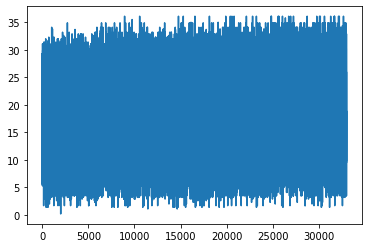

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/variat_2_(base_7x7)/scores.npy')

plt.plot(scores_history)
plt.show()

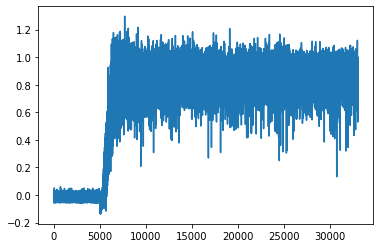

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/variat_2_(base_7x7)/average_scores.npy')

plt.plot(scores_history)
plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/diplom/variat_2_(base_7x7)/'
episode_start, global_step = np.load(os.path.join(checkpoint_dir, 'step_info.npy')).tolist()
scores = np.load(os.path.join(checkpoint_dir, 'scores.npy')).tolist()
average_scores = np.load(os.path.join(checkpoint_dir, 'average_scores.npy')).tolist()
playfield_size = 7
mines_count = 8
epsilon = 0.46
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_size)
agent = Agent(playfield_size, epsilon)

In [ ]:
step_field = test_minesweeper_game()


-0.44    -0.42    -0.43    -0.48    -0.43    -0.46    -0.4     -0.45    
-0.47    -0.45    -0.47    -0.47    -0.34    -0.57    -0.45    -0.44    
-0.46    -0.44    -0.46    0.72     0.74     -0.45    -0.46    -0.45    
-0.39    -0.53    0.96     -1.15    -0.44    -0.42    -0.43    -0.44    
-0.38    0.95     0.88     -0.42    -0.47    -0.45    -0.48    -0.41    
-0.54    -0.48    -0.42    -0.43    -0.47    -0.46    -0.44    -0.45    
-0.4     



-0.44    -0.41    -0.37    0.96     -1.17    -1.6     -0.99    -0.45    
-0.43    -0.39    -0.88    -1.01    -1.56    -1.21    -0.45    -0.44    
-0.43    0.54     -1.04    -1.82    -1.51    -0.45    -0.48    -0.42    
-0.36    -1.55    -1.45    -0.97    -0.44    -0.44    -0.49    0.93     
-1.03    -2.02    -1.04    -0.42    -0.47    -0.42    -0.32    -0.41    
-0.65    -0.02    -0.42    -0.43    -0.42    -0.49    -0.4     -0.44    
-0.46    



-0.47    -0.37    -0.52    0.9      -1.54    -1.67    -0.97    -0.42    
-0.44    -0.32    -1.02 

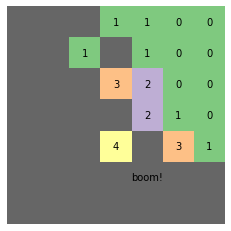

In [ ]:
result_dir = '/content/result_images/'

if os.path.exists(result_dir) is True:
  shutil.rmtree(result_dir)

os.mkdir(result_dir)

for i, field in enumerate(step_field):
  clear_output(wait=1000)
  show_result(field, i, test_minesweeper.free_point, test_minesweeper.mines_coord)

In [ ]:
train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=True)

Streaming output truncated to the last 5000 lines.
ep: 60440   s.: 36.1   mem.len: 40000   eps: 0.18   g_step: 333039   av_q: 0.66   av_loss: 0.0044592
ep: 60441   s.: 13.4   mem.len: 40000   eps: 0.18   g_step: 333042   av_q: 0.797   av_loss: 0.0036723
ep: 60442   s.: 18.2   mem.len: 40000   eps: 0.18   g_step: 333057   av_q: 0.85   av_loss: 0.0023776
ep: 60443   s.: 7.7   mem.len: 40000   eps: 0.18   g_step: 333062   av_q: 0.781   av_loss: 0.004097
ep: 60444   s.: 18.8   mem.len: 40000   eps: 0.18   g_step: 333066   av_q: 0.834   av_loss: 0.0032375
ep: 60445   s.: 23.0   mem.len: 40000   eps: 0.18   g_step: 333075   av_q: 0.74   av_loss: 0.0038544
ep: 60446   s.: 24.2   mem.len: 40000   eps: 0.18   g_step: 333082   av_q: 0.836   av_loss: 0.0059704
ep: 60447   s.: 29.6   mem.len: 40000   eps: 0.18   g_step: 333088   av_q: 0.834   av_loss: 0.0038233
ep: 60448   s.: 9.8   mem.len: 40000   eps: 0.18   g_step: 333090   av_q: 0.833   av_loss: 0.0060288
ep: 60449   s.: 24.2   mem.len: 40000

## 3 iteration

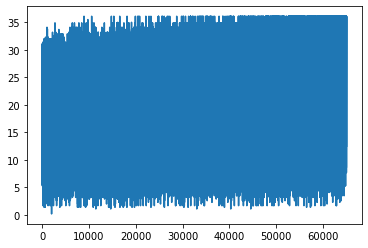

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/variat_2_(base_7x7)/scores.npy')

plt.plot(scores_history)
plt.show()

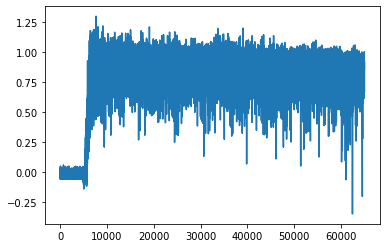

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/variat_2_(base_7x7)/average_scores.npy')

plt.plot(scores_history)
plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/diplom/variat_2_(base_7x7)/'
episode_start, global_step = np.load(os.path.join(checkpoint_dir, 'step_info.npy')).tolist()
scores = np.load(os.path.join(checkpoint_dir, 'scores.npy')).tolist()
average_scores = np.load(os.path.join(checkpoint_dir, 'average_scores.npy')).tolist()
playfield_size = 7
mines_count = 8
epsilon = 0.0
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_size)
agent = Agent(playfield_size, epsilon)

In [ ]:
step_field = test_minesweeper_game()


-0.43    -0.38    -0.49    -0.38    -0.47    -0.46    -0.4     
-0.39    -0.45    -0.45    -0.38    -0.44    -0.35    -0.4     
-0.4     -0.34    -0.46    -0.32    -0.47    -0.29    -0.35    
-0.3     -0.26    -0.5     -0.45    -0.41    0.03     -0.28    
-0.4     -0.49    0.89     0.87     0.86     -0.37    -0.41    
-0.38    -0.26    0.77     -3.14    0.74     -0.35    -0.34    
-0.43    -0.4     0.59     0.9      0.65     -0.42    -0.47    



-0.36    -0.72    0.44     0.82     0.85     -0.47    -0.5     
-0.97    -2.9     -1.57    -1.56    -0.85    0.79     -0.36    
-1.81    -1.62    -1.86    -1.18    -1.33    0.67     -0.28    
-2.03    -2.69    -1.78    -1.18    -0.99    -0.87    0.1      
-1.58    -1.59    -0.61    -1.35    -1.0     -1.03    0.75     
-2.09    -1.99    -1.36    -1.66    -1.46    -1.48    -0.23    
-2.72    -1.51    -1.25    -1.52    -1.08    -1.05    0.63     



-0.36    -0.55    0.48     0.89     -1.35    0.45     -0.45    
-0.97    -3.02    -1.66    -1.3  

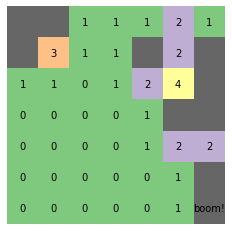

In [ ]:
result_dir = '/content/result_images/'

if os.path.exists(result_dir) is True:
  shutil.rmtree(result_dir)

os.mkdir(result_dir)

for i, field in enumerate(step_field):
  clear_output(wait=1000)
  show_result(field, i, test_minesweeper.free_point, test_minesweeper.mines_coord)

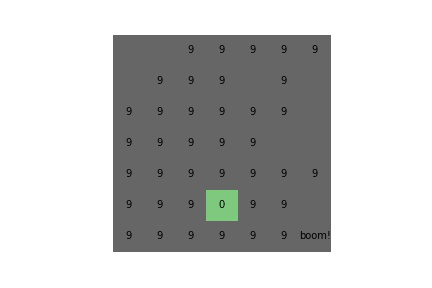

In [ ]:
images = [imageio.imread(os.path.join(result_dir, str(id) + '.jpg')) for id in range(len(os.listdir(result_dir)))]
imageio.mimsave('mw.gif', images)
Image(open('mw.gif','rb').read())

In [ ]:
score = 0
n = 500

for i in range(1, n+1):
  curr_result = check_winrate()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 33.0 %
200 games - winrate 33.5 %
300 games - winrate 33.0 %
400 games - winrate 33.0 %
500 games - winrate 31.4 %
Total winrate 31.4 %


In [ ]:
train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=True)

Streaming output truncated to the last 5000 lines.
ep: 69062   s.: 36.1   mem.len: 40000   eps: 0.0   g_step: 421991   av_q: 0.778   av_loss: 0.0058654
ep: 69063   s.: 23.3   mem.len: 40000   eps: 0.0   g_step: 421997   av_q: 0.839   av_loss: 0.0184799
ep: 69064   s.: 30.5   mem.len: 40000   eps: 0.0   g_step: 422008   av_q: 0.761   av_loss: 0.010581
ep: 69065   s.: 36.1   mem.len: 40000   eps: 0.0   g_step: 422020   av_q: 0.797   av_loss: 0.005762
ep: 69066   s.: 36.1   mem.len: 40000   eps: 0.0   g_step: 422041   av_q: 0.744   av_loss: 0.0048055
ep: 69067   s.: 36.1   mem.len: 40000   eps: 0.0   g_step: 422057   av_q: 0.795   av_loss: 0.0038252
ep: 69068   s.: 34.1   mem.len: 40000   eps: 0.0   g_step: 422069   av_q: 0.828   av_loss: 0.0082854
ep: 69069   s.: 31.4   mem.len: 40000   eps: 0.0   g_step: 422084   av_q: 0.849   av_loss: 0.0081596
ep: 69070   s.: 26.9   mem.len: 40000   eps: 0.0   g_step: 422091   av_q: 0.782   av_loss: 0.0107583
ep: 69071   s.: 21.5   mem.len: 40000   ep

## 4 iteration

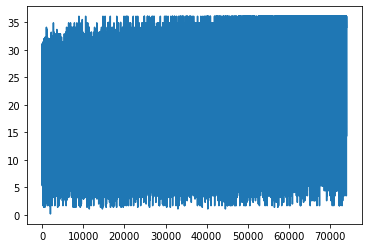

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/variat_2_(base_7x7)/scores.npy')

plt.plot(scores_history)
plt.show()

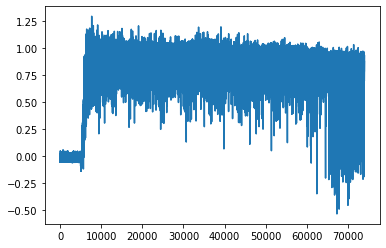

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/variat_2_(base_7x7)/average_scores.npy')

plt.plot(scores_history)
plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/diplom/variat_2_(base_7x7)/'
episode_start, global_step = np.load(os.path.join(checkpoint_dir, 'step_info.npy')).tolist()
scores = np.load(os.path.join(checkpoint_dir, 'scores.npy')).tolist()
average_scores = np.load(os.path.join(checkpoint_dir, 'average_scores.npy')).tolist()
playfield_size = 7
mines_count = 8
epsilon = 0.0
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_size)
agent = Agent(playfield_size, epsilon)

In [ ]:
step_field = test_minesweeper_game()


-0.4     -0.4     -0.29    -0.39    -0.56    -0.37    -0.37    -0.41    
-0.17    0.85     0.82     0.85     -0.34    -0.39    -0.37    -0.28    
0.77     -0.77    0.95     -0.29    -0.29    -0.36    -0.09    0.93     
0.91     0.76     -0.24    -0.34    -0.37    -0.25    -0.24    -0.31    
-0.33    -0.29    -0.31    -0.36    -0.38    -0.4     -0.32    -0.34    
-0.36    -0.3     -0.39    -0.38    -0.4     -0.37    -0.4     -0.4     
-0.31    



0.47     -0.93    -1.68    -1.08    -0.28    -1.27    -0.98    -0.85    
-1.19    -1.29    -1.25    -0.64    -0.79    -1.59    -0.89    -1.14    
-1.34    -0.62    -0.94    -0.88    -0.74    -0.96    -1.12    -0.79    
-0.71    -0.81    -0.89    -1.78    0.93     -1.34    -0.59    -0.89    
-1.0     -0.88    0.88     -0.2     -1.83    -1.09    -2.57    -1.09    
0.69     -0.43    0.94     -1.64    -1.57    -2.89    -1.14    0.89     
-0.39    



0.47     -0.93    -1.68    -1.08    -0.28    -1.27    -0.98    -0.85    
-1.19    -1.29    -1.25 

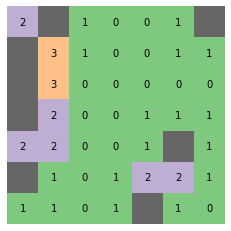

In [ ]:
result_dir = '/content/result_images/'

if os.path.exists(result_dir) is True:
  shutil.rmtree(result_dir)

os.mkdir(result_dir)

for i, field in enumerate(step_field):
  clear_output(wait=1000)
  show_result(field, i, test_minesweeper.free_point, test_minesweeper.mines_coord)

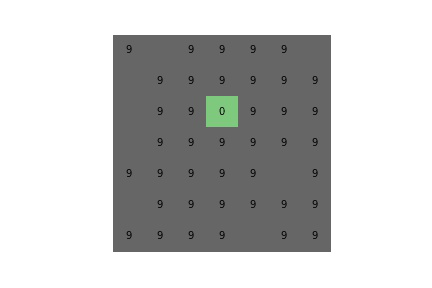

In [ ]:
images = [imageio.imread(os.path.join(result_dir, str(id) + '.jpg')) for id in range(len(os.listdir(result_dir)))]
imageio.mimsave('mw.gif', images)
Image(open('mw.gif','rb').read())

In [ ]:
score = 0
n = 500

for i in range(1, n+1):
  curr_result = check_winrate()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 30.0 %
200 games - winrate 31.0 %
300 games - winrate 35.0 %
400 games - winrate 34.75 %
500 games - winrate 36.2 %
Total winrate 36.2 %


In [ ]:
train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=True)

Streaming output truncated to the last 5000 lines.
ep: 78453   s.: 30.5   mem.len: 40000   eps: 0.0   g_step: 534678   av_q: 0.899   av_loss: 0.0091538
ep: 78454   s.: 17.9   mem.len: 40000   eps: 0.0   g_step: 534682   av_q: 0.871   av_loss: 0.0329999
ep: 78455   s.: 36.1   mem.len: 40000   eps: 0.0   g_step: 534694   av_q: 0.828   av_loss: 0.0046627
ep: 78456   s.: 36.1   mem.len: 40000   eps: 0.0   g_step: 534708   av_q: 0.884   av_loss: 0.0042625
ep: 78457   s.: 23.3   mem.len: 40000   eps: 0.0   g_step: 534716   av_q: 0.881   av_loss: 0.0124607
ep: 78458   s.: 36.1   mem.len: 40000   eps: 0.0   g_step: 534726   av_q: 0.894   av_loss: 0.0037442
ep: 78459   s.: 33.2   mem.len: 40000   eps: 0.0   g_step: 534744   av_q: 0.821   av_loss: 0.0075491
ep: 78460   s.: 17.0   mem.len: 40000   eps: 0.0   g_step: 534750   av_q: 0.897   av_loss: 0.0221118
ep: 78461   s.: 34.1   mem.len: 40000   eps: 0.0   g_step: 534770   av_q: 0.83   av_loss: 0.0047243
ep: 78462   s.: 18.8   mem.len: 40000   e